# 多元高斯

多维不确定性建模

In [2]:
%matplotlib inline
#format the book
import lean.book_format as book_format
book_format.set_style()

## 一、介绍

上一章中的技术非常强大，但它们只适用于一个变量或维度。它们无法表示多维数据，例如狗在田野中的位置和速度。位置和速度是相互关联的，正如我们在g-h章节中学到的那样，我们永远不应该丢弃信息。在本章中，我们将学习如何以概率方式描述这种关系。通过这一关键见解，我们将实现明显更好的滤波器性能。

## 二、多元正态分布

我们一直在使用高斯作为标量随机变量，表示为 $\mathcal{N}(\mu, \sigma^2)$。一个更正式的术语是单变量正态，其中单变量表示“一个变量”。高斯的概率分布称为单变量正态分布。

多元正态分布可能是什么？多元意味着多变量。我们的目标是能够表示具有多个维度的正态分布。我不一定是指空间维度——如果我们以（x，y，z）跟踪飞机的位置，速度和加速度，就会给我们一个九维问题。考虑一个二维案例。它可能是机器人的x和y坐标，可能是狗在x轴上的位置和速度，或者奶牛场的产奶量和饲料速率。这并不重要。我们可以看到 𝑁 尺寸，我们需要 𝑁 表示，我们将在列矩阵（向量）中排列，如下所示：

$$
\mu = \begin{bmatrix}\mu_1\\\mu_2\\ \vdots \\\mu_n\end{bmatrix}
$$

假设我们相信 $x = 2$ 和 $y = 17$ 。我们会有

$$
\mu = \begin{bmatrix}2\\17\end{bmatrix} 
$$

下一步是表示我们的方差。乍一看，我们可能会认为我们还需要 N 个维度的 N 个方差。我们可能想说 x 的方差是 10，y 的方差是 4，就像这样。

$$\sigma^2 = \begin{bmatrix}10\\4\end{bmatrix}$$ 

这是不完整的，因为它没有考虑更一般的情况。在高斯一章中，我们计算了学生身高的变化。这是衡量高度如何相对于彼此变化的度量。如果所有学生的身高相同，则方差为 0，如果他们的身高相差很大，则方差会很大。

身高和体重之间也有关系。一般来说，较高的人比矮个子的人体重更重。身高和体重是相关的。我们想要一种方法，不仅要表达我们认为身高和体重的差异，还要表达它们的相关性程度。换句话说，我们想知道体重与身高相比如何变化。我们称之为协方差。

在我们理解多元正态分布之前，我们需要了解相关性和协方差背后的数学原理。


### 相关性和协方差

协方差描述了两个变量一起变化的程度。协方差是相关性差异的缩写。换句话说，方差是衡量一个群体之间的差异，协方差是两个变量之间变化程度的度量。例如，随着身高的增加，体重通常也会增加。这些变量是相关的。它们是正相关的，因为当一个变量变大时，另一个变量也会变大。随着室外温度的降低，家庭取暖费用增加。这些变量呈负相关或负相关，因为当一个变量变大时，另一个变量会降低。茶的价格和我的狗摇尾巴的数量彼此没有关系，我们说它们是不相关的或独立的——每个都可以相互独立地变化。

相关性允许预测。如果你比我高得多，我可以预测你也比我重。随着冬天的到来，我预测我将花更多的钱来取暖。如果我的狗摇尾巴更多，我不会得出茶叶价格会发生变化的结论。

例如，这是学校田径队学生的身高和体重图。如果一个学生身高68英寸，我可以预测他们的体重约为160磅。由于相关性不完美，我的预测也不完美。

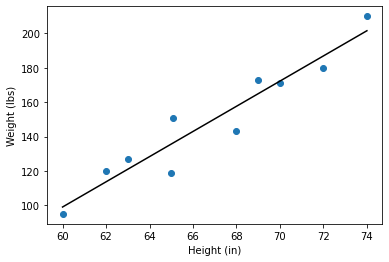

In [1]:
from lean.kf_book.gaussian_internal import plot_correlated_data

height = [60, 62, 63, 65, 65.1, 68, 69, 70, 72, 74]
weight = [95, 120, 127, 119, 151, 143, 173, 171, 180, 210]
plot_correlated_data(height, weight, 'Height (in)', 'Weight (lbs)', False)

在本书中，我们只考虑线性相关。我们假设变量之间的关系是线性的。也就是说，直线非常适合数据。我在上图中的数据中拟合了一条直线。非线性相关的概念是存在的，但我们不会使用它。

之间的协方差方程 $X$ 和 $Y$ 是

$$ COV(X, Y) = \sigma_{xy} = \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]$$

其中， $\mathbb E[X]$ 是 X 的期望值, 被定义为

$$\mathbb E[X] =  \begin{cases} \sum_{i=1}^n p_ix_i & \text{离散}\\ \int_{-\infty}^\infty f(x)\, x & \text{连续}\end{cases}$$

我们假设每个数据点的可能性相等，因此每个数据点的概率为$\frac{1}{N}$

$$\mathbb E[X] =  \frac{1}{N}\sum_{i=1}^n x_i$$

对于我们将考虑的离散情况。

将协方差方程与方差方程进行比较。如您所见，它们非常相似：

$$\begin{aligned}VAR(X) = \sigma_x^2 &= \mathbb E[(X - \mu)^2]\\
COV(X, Y) = \sigma_{xy} &= \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]\end{aligned}$$

特别是，如果您计算  $COV(X, X)$ 你得到的等式  $VAR(X)$ ，这支持了我的说法，即方差计算随机变量在自身之间如何变化。

我们使用协方差矩阵来表示多元正态分布的协方差，它看起来像这样：

$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

对角线包含每个变量的方差，非对角线元素包含$i^{th}$ 和 $j^{th}$ 变量之间的协方差。所以 $\sigma_3^2$ 是第三个变量的方差，并且 $\sigma_{13}$ 是第一个变量和第三个变量之间的协方差。协方差为 0 表示没有相关性。如果 𝑥 的方差为 10，𝑦 的方差为4，并且 𝑥 和 𝑦 之间没有线性相关性，然后我们会写

$$\Sigma = \begin{bmatrix}10&0\\0&4\end{bmatrix}$$

如果𝑥 和 𝑦两者之间存在少量正相关，我们可能有

$$\Sigma = \begin{bmatrix}10&1.2\\1.2&4\end{bmatrix}$$

其中 1.2 是两者之间的协方差。我说相关性是“小”的，因为 1.2 的协方差相对于 10 的方差很小。

如果两者之间存在大量的负相关关系，我们可能有

$$\Sigma = \begin{bmatrix}10&-9.7\\-9.7&4\end{bmatrix}$$

协方差矩阵是对称的。毕竟，$x$ 和 $y$两者之间的协方差始终等于$y$ and $x$之间的协方差。也就是$\sigma_{xy}=\sigma_{yx}$，对于任何$x$ 和 $y$。

我担心我可能让你迷惑，所以让我们举个例子。在高斯章节中，我们有一班学生的身高为 H=[1.8， 2.0， 1.7， 1.9， 1.6] 米。我们计算：


$$\begin{aligned}
\mathit{VAR}(H) &= E[(H - \mu_H)^2] \\
&= \frac{1}{N}\sum_{i=1}^n (H_i - \mu_H)^2 \\
&= \frac{1}{5}\left[(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2\right] \\
&= 0.02
\end{aligned}$$

很简单，对吧？如果我们对学生进行称重，我们可能会发现他们的权重为 W = [70.1， 91.2， 59.5， 93.2， 53.5]。我们可以使用协方差方程来创建协方差矩阵吗？当然，它将看起来像：

$$\Sigma = \begin{bmatrix}\sigma_H^2 & \sigma_{H,W} \\
\sigma_{W,H} & \sigma_{W}^2\end{bmatrix}$$

我们刚刚计算了高度的方差，它将位于矩阵的左上角。右下角包含权重的方差。使用相同的等式，我们得到：

